In [60]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from typing import TypedDict, Dict,List
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import os
load_dotenv()

True

In [61]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
tavaly_search = TavilySearchResults()

In [62]:
class ResearchState(TypedDict):
    input_query: str
    sub_questions: List[str]
    search_results: Dict[str, List[str]]
    missing_info: List[str]
    contradictions: List[str]
    summary: str
    report: str
    complete: bool

In [63]:
import re
def extract_list(text: str) -> list[str]:
    # Match lines starting with a number, dash, or bullet
    lines = re.findall(r"(?:\d+\.\s*|-|\*)\s*(.+)", text)
    if lines:
        return [line.strip() for line in lines if line.strip()]
    
    # Fallback: split by newlines
    return [line.strip() for line in text.strip().split("\n") if line.strip()]

In [64]:
def decomposer(state: ResearchState) -> ResearchState:
    prompt = f"Break this complex question into 3-5 researchable sub-questions:\n{state['input_query']}"
    response = llm.invoke(prompt)
    state['sub_questions'] = extract_list(response.content)
    return state


In [65]:
def web_searcher(sub_question: str) -> List[str]:
    return tavaly_search.invoke(sub_question)['snippets']  # pseudo-code


In [66]:
def parallel_search(state: ResearchState) -> ResearchState:
    results = {}
    for sub_q in state['sub_questions']:
        results[sub_q] = web_searcher(sub_q)
    state['search_results'] = results
    return state


In [67]:
def evaluator(state: ResearchState) -> ResearchState:
    missing = []
    for sub_q, results in state['search_results'].items():
        if not results or len(results) < 2:
            missing.append(sub_q)
    state['missing_info'] = missing
    return state


In [68]:
def summarizer(state: ResearchState) -> ResearchState:
    summaries = []
    for sub_q, texts in state['search_results'].items():
        combined_text = " ".join(texts)
        summary = llm.invoke(f"Summarize findings for: {sub_q}\n{combined_text}")
        summaries.append(f"**{sub_q}**:\n{summary.content}")
    state['summary'] = "\n\n".join(summaries)
    return state


In [69]:
def contradiction_checker(state: ResearchState) -> ResearchState:
    prompt = f"Review the following summaries and identify contradictions:\n{state['summary']}"
    contradictions = llm.invoke(prompt)
    state['contradictions'] = extract_list(contradictions.content)
    return state


In [70]:
def reporter(state: ResearchState) -> ResearchState:
    prompt = f"""Create a final research report based on:
    
    - Summary: {state['summary']}
    - Contradictions: {state['contradictions']}
    - Missing Info: {state['missing_info']}

    Format it with proper markdown and citations if any.
    """
    state['report'] = llm.invoke(prompt).content
    state['complete'] = True
    return state


In [71]:
def decide_next(state: ResearchState) -> str:
    if "missing_info" in state and len(state["missing_info"]) > 0:
        return "search"
    else:
        return "summarizer"



In [72]:

graph = StateGraph(ResearchState)

graph.add_node("decomposer", decomposer)
graph.add_node("search", parallel_search)
graph.add_node("evaluator", evaluator)
graph.add_node("summarizer", summarizer)
graph.add_node("contradiction_checker", contradiction_checker)
graph.add_node("reporter", reporter)

graph.set_entry_point("decomposer")

graph.add_edge("decomposer", "search")
graph.add_edge("search", "evaluator")

# ✅ Conditional routing function
def decide_next(state: ResearchState) -> str:
    return "search" if state.get("missing_info") else "summarizer"

graph.add_conditional_edges("evaluator", decide_next)

graph.add_edge("evaluator", "search")        # fallback
graph.add_edge("evaluator", "summarizer")  

graph.add_edge("summarizer", "contradiction_checker")
graph.add_edge("contradiction_checker", "reporter")

graph.set_finish_point("reporter")

# --------- Compile & Visualize ---------
app = graph.compile()



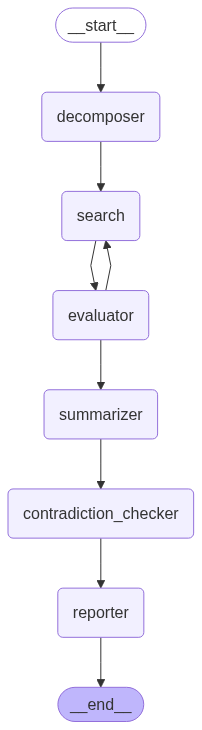

In [73]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [74]:
input_state = {
    "input_query": "What are the economic and environmental effects of lithium mining?",
    "sub_questions": [],
    "search_results": {},
    "missing_info": [],  # change to ["Q1"] to test other path
    "contradictions": [],
    "summary": "",
    "report": "",
    "complete": False,
}

result = app.invoke(input_state)
print(result["report"])

TypeError: list indices must be integers or slices, not str